## John Peters Final Project

### Research Question 
Which enriched DNA sequence motifs lead to the most significant increase in the STARR-Seq signal strength that is observed in our data?​

### Hypothesis
The way that I am treating modeling in this product is to describe my data. I don't have the traditional (to what the courses we take teach) expectation of classification or linear regression. 

What I will do is use a linear model to see which features help describe the response variable. I do not think I can have a hypothesis in this case, because I'm not trying to prove or disprove anything, I am just trying to 

### Dataset
I have a few pieces of data that I will be using. First is the genome of the insect I am doing this research on. It is the reference genome of the Drosophila melanogaster. I think the one that I am using is from a group called FlyBase. Drosophila melanogaster is a reference insect for a lot of science, so it was made so that people could use them for research and then try to corroborate that research on their actual target organism.

Next are a list of peaks from STARR-seq. This was ran to try to find enhancers within the Drosophila melanogaster. This data is from a paper first authored by Cosmas D Arnold about running STARR-seq on Drosophila melanogaster cells.

These are the two datasets I am using in my research. I am getting my response variable from the second dataset, and the first one to engineer features from.

NOTE: To see what work was done to engineer features see file logistic_regression_feature_engineering.ipynb


In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from functions import *

sns.set_style("white")
plt.rcParams['figure.dpi'] = 75

### Data Preprocessing

NOTE: See file: logistic_regression_feature_engineering.ipynb for further information on how features were engineered. Cleanly compiled code for that segment is in file functions.py


In [23]:
wide_matrix = get_linear_regression_matrix()

### Again, look at the other files if you want to see my exploratory process. There are some visuals and a lot more description in them I strongly recommend you pitstop into logistic_regression_feature_engineering.ipynb

In [24]:
wide_matrix.head()

,sequence_name,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,...,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47,signal_value
0,X:5794883-5797178,0,0,0,0,0,0,0,1,1,...,3,0,0,0,1,30,2,0,0,48
1,3L:17576814-17578210,0,0,0,16,1,2,0,2,1,...,1,0,0,1,1,6,1,2,0,654
2,2R:15744192-15745896,1,0,2,0,0,0,0,0,1,...,1,2,0,0,1,10,0,0,0,443
3,2R:14048903-14050073,2,0,2,0,0,0,0,0,0,...,2,0,0,0,8,10,0,0,0,1519
4,2R:24969269-24969879,0,2,0,0,0,1,0,0,0,...,0,0,0,0,1,4,1,0,0,88


Text(0.5, 1.0, 'Signal value from narrowpeak')

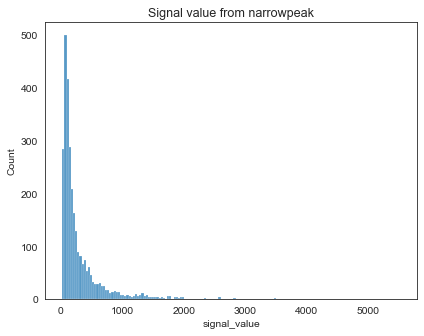

In [25]:
sns.histplot(data=wide_matrix, x='signal_value')
plt.title('Signal value from narrowpeak')

This is fairly skewed and spans quite a large range. I will take the log transform

In [26]:
wide_matrix.signal_value = np.log(wide_matrix.signal_value)

Text(0.5, 1.0, 'Log transformed signal value')

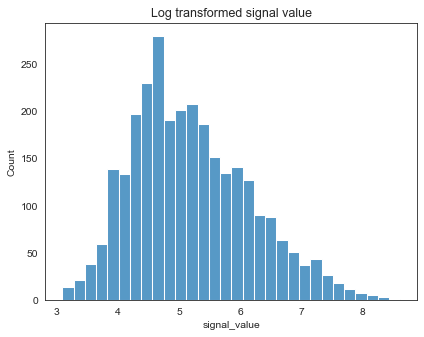

In [27]:
sns.histplot(data=wide_matrix, x='signal_value')
plt.title('Log transformed signal value')

That looks much better. We will use this.

Now to create our model and see how well it performs (I will qualify it later)

In [28]:
features = wide_matrix.iloc[:, 1:-1]
response = wide_matrix.iloc[:, -1:]

In [29]:
features.head()

,STREME-1,STREME-2,STREME-3,STREME-4,STREME-5,STREME-6,STREME-7,STREME-9,STREME-10,STREME-11,...,STREME-36,STREME-37,STREME-38,STREME-41,STREME-42,STREME-43,STREME-44,STREME-45,STREME-46,STREME-47
0,0,0,0,0,0,0,0,1,1,0,...,0,3,0,0,0,1,30,2,0,0
1,0,0,0,16,1,2,0,2,1,0,...,0,1,0,0,1,1,6,1,2,0
2,1,0,2,0,0,0,0,0,1,0,...,0,1,2,0,0,1,10,0,0,0
3,2,0,2,0,0,0,0,0,0,0,...,7,2,0,0,0,8,10,0,0,0
4,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,4,1,0,0


In [30]:
response.head()

,signal_value
0,3.871201
1,6.483107
2,6.093570
3,7.325808
4,4.477337


### Data Analysis and Visualization

In [31]:
df_to_statsmodels = pd.DataFrame()


# Renaming the training data features without the dash so statsmodels can stop complaining 
rename_X = {}
for column in features.columns:
    rename_X[column] = "".join(column.split('-'))

X_train = features.rename(columns=rename_X)

df_to_statsmodels = pd.concat([df_to_statsmodels, X_train], axis=1)
print(df_to_statsmodels.shape)
df_to_statsmodels['signal_strength'] = response
df_to_statsmodels.head()

(2902, 36)


,STREME1,STREME2,STREME3,STREME4,STREME5,STREME6,STREME7,STREME9,STREME10,STREME11,...,STREME37,STREME38,STREME41,STREME42,STREME43,STREME44,STREME45,STREME46,STREME47,signal_strength
0,0,0,0,0,0,0,0,1,1,0,...,3,0,0,0,1,30,2,0,0,3.871201
1,0,0,0,16,1,2,0,2,1,0,...,1,0,0,1,1,6,1,2,0,6.483107
2,1,0,2,0,0,0,0,0,1,0,...,1,2,0,0,1,10,0,0,0,6.093570
3,2,0,2,0,0,0,0,0,0,0,...,2,0,0,0,8,10,0,0,0,7.325808
4,0,2,0,0,0,1,0,0,0,0,...,0,0,0,0,1,4,1,0,0,4.477337


Note: The above table was visualized in the logistic_regression_feature_engineering.ipynb notebook

### Data Modeling and Prediction

In [32]:
model_string = "signal_strength ~ "
for col in X_train.columns:
    if col != "signal_strength":
        model_string += f"{col} + "

model_string = model_string[:-2]
# model_string = f'{model_string} - 1'

y, X = dmatrices(model_string, data=df_to_statsmodels, return_type="dataframe")
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2902 entries, 0 to 2901
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Intercept  2902 non-null   float64
 1   STREME1    2902 non-null   float64
 2   STREME2    2902 non-null   float64
 3   STREME3    2902 non-null   float64
 4   STREME4    2902 non-null   float64
 5   STREME5    2902 non-null   float64
 6   STREME6    2902 non-null   float64
 7   STREME7    2902 non-null   float64
 8   STREME9    2902 non-null   float64
 9   STREME10   2902 non-null   float64
 10  STREME11   2902 non-null   float64
 11  STREME12   2902 non-null   float64
 12  STREME13   2902 non-null   float64
 13  STREME14   2902 non-null   float64
 14  STREME15   2902 non-null   float64
 15  STREME16   2902 non-null   float64
 16  STREME17   2902 non-null   float64
 17  STREME18   2902 non-null   float64
 18  STREME19   2902 non-null   float64
 19  STREME20   2902 non-null   float64
 20  STREME21

Again, it's all not null because of how this dataset was gathered. The following little bit of code is just me creating my model using statsmodels.

No train/test split because we are trying to understand our data with this model. It is simply an exploratory tool. It is not ever going to be used to predict on new data!

In [33]:
linear_model = sm.OLS(y, X)
results = linear_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        signal_strength   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     16.60
Date:                Mon, 20 Feb 2023   Prob (F-statistic):           2.29e-92
Time:                        20:47:22   Log-Likelihood:                -3740.2
No. Observations:                2902   AIC:                             7554.
Df Residuals:                    2865   BIC:                             7775.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6089      0.031    151.020      0.000       4.549       4.669
STREME1        0.1166      0.025      4.689      0.000       0.068       0.165
STREME2        0.0123      0.024      0.503      0.615      -0.036       0.060
STREME3        0.1062      0.017      6.106      0.000       0.072       0.140
STREME4        0.0112      0.008      1.481      0.139      -0.004       0.026
STREME5        0.0369      0.019      1.917      0.055      -0.001       0.075
STREME6       -0.0294      0.020     -1.450      0.147      -0.069       0.010
STREME7        0.0469      0.032      1.461      0.144      -0.016       0.110
STREME9        0.0223      0.014      1.561      0.119      -0.006       0.050
STREME10       0.0965      0.030      3.257      0.001       0.038       0.155
STREME11       0.1385      0.044      3.182      0.001       0.053       0.224
STREME12       0.0028      0.006      0.436      0.663      -0.010       0.015
STREME13       0.0027      0.031      0.088      0.930      -0.058       0.063
STREME14       0.1252      0.030      4.186      0.000       0.067       0.184
STREME15      -0.0101      0.013     -0.773      0.439      -0.036       0.016
STREME16       0.0295      0.040      0.739      0.460      -0.049       0.108
STREME17      -0.0193      0.011     -1.697      0.090      -0.042       0.003
STREME18       0.0462      0.032      1.451      0.147      -0.016       0.109
STREME19       0.0379      0.036      1.044      0.296      -0.033       0.109
STREME20       0.1171      0.031      3.821      0.000       0.057       0.177
STREME21       0.0975      0.031      3.182      0.001       0.037       0.157
STREME22       0.0540      0.031      1.754      0.080      -0.006       0.114
STREME23      -0.0006      0.049     -0.012      0.990      -0.096       0.095
STREME25       0.0986      0.039      2.528      0.012       0.022       0.175
STREME29       0.0768      0.045      1.689      0.091      -0.012       0.166
STREME31       0.0528      0.040      1.324      0.186      -0.025       0.131
STREME35       0.0730      0.035      2.111      0.035       0.005       0.141
STREME36       0.0262      0.022      1.197      0.231      -0.017       0.069
STREME37       0.0499      0.020      2.510      0.012       0.011       0.089
STREME38       0.0519      0.014      3.677      0.000       0.024       0.080
STREME41       0.0759      0.041      1.844      0.065      -0.005       0.157
STREME42       0.0718      0.034      2.093      0.036       0.005       0.139
STREME43       0.0322      0.016      2.021      0.043       0.001       0.063
STREME44       0.0062      0.010      0.646      0.518      -0.013       0.025
STREME45       0.0574      0.027      2.117      0.034       0.004       0.111
STREME46       0.0487      0.031      1.585      0.113      -0.012       0.109
ST

Looking at the results from our model, we see there is a p value. This p value is for the Wald test. The Wald test will tell us if certain features are 0 (null hypothesis). And if they are zero, that means that they aren't impactful towards the model. But if we reject the null hypothesis then our feature is significant. 

Statsmodels will do this for every single variable individually, and does not do it for the collective set of variables. Though that is an option that is possible with the Wald test if my interpretation is correct.

Additionally, it is visible that our adjusted $R^2$ is 0.162. This means that 16.2% of our variance is able to be observed from this model.

Text(0.5, 1.0, 'This is a funny graph about peak height')

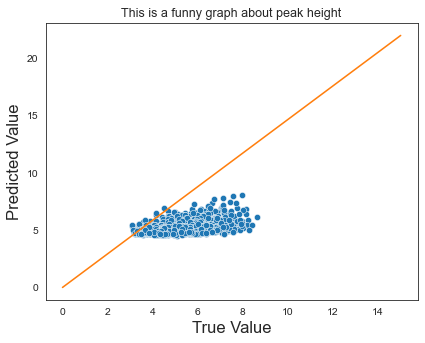

In [34]:
# X_test['Intercept'] = np.ones(X_test.shape[0])
# print(X_test.shape)
pred_y = results.predict(X)
sns.scatterplot(x=response['signal_value'], y=pred_y)
plt.plot([0, 15], [0, 22], color="tab:orange")
plt.xlabel("True Value", fontsize=16)
plt.ylabel("Predicted Value", fontsize=16)
plt.title("This is a funny graph about peak height")

We are predicting on our same training data here. This just tells us how well the model is able to understand our data. We can see here from the line that the true value and predicted value don't really match most of the time.

Our model is not understanding how our data is varying well. This matches what we were seeing from the $R^2$ value from before.

### Linear Regression assumptions

Text(0.5, 1.0, 'Residual Histogram')

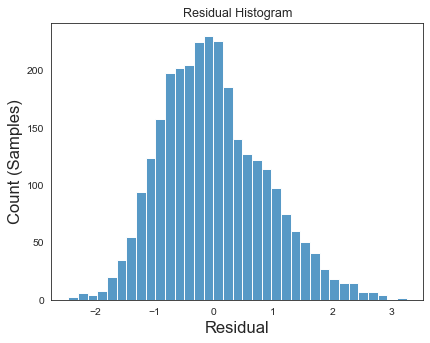

In [39]:
sns.histplot(x=results.resid)
plt.xlabel("Residual", fontsize=16)
plt.ylabel("Count (Samples)", fontsize=16)
plt.title("Residual Histogram")

By using a histogram of the residuals, we can see that they are roughly normally distributed. I think that the normality assumption is likely to be true with distribution.

Checking if our data is normally distributed

In [36]:
stats.shapiro(results.resid)

ShapiroResult(statistic=0.9860913753509521, pvalue=2.8490914033897934e-16)

The Shapiro test from scipy shows us exactly what the graph above showed us. That we have normally distributed residuals.

Checking the mean residuals

In [37]:
np.mean(results.resid)

5.1270726694750164e-15

This is really close to zero. Again, this strengthens our assumption of normally distributed residuals.

Checking the residuals vs fitted values (should be roughly consistent going left to right)

Text(0.5, 1.0, 'Residuals vs fitted values')

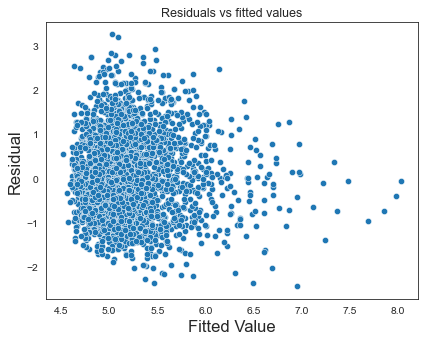

In [82]:
sns.scatterplot(x=results.fittedvalues, y=results.resid)
plt.xlabel("Fitted Value", fontsize=16)
plt.ylabel("Residual", fontsize=16)
plt.title("Residuals vs fitted values")

Yeeea. That right there is the bad one. There we go. We don't have constant residuals, now it makes sense why our model is like it is.

Though we understood that by looking at the prediction from earlier. This just centers it around that 0 line and makes it horizontal. We understood that our data was not exactly linear from previous analysis.

### Results Analysis

Bringing ourselves back to the question I wanted to answer, I will simply list the appropriate motifs that seem to have some relationship with the signal response.

We will use an $\alpha$ of 0.05 and use the results of the Wald test for this.

In [66]:
model_with_weights = list(dict(results.params).items())
significant_features = []
for index, p_val in enumerate(results.pvalues):
    if p_val <= 0.05:
        significant_features.append(model_with_weights[index][0])

significant_features = significant_features[1:]
renamed_significant_features = [f'STREME-{split_line.split("STREME")[1]}' for split_line in significant_features]
renamed_significant_features

['STREME-1',
 'STREME-3',
 'STREME-10',
 'STREME-11',
 'STREME-14',
 'STREME-20',
 'STREME-21',
 'STREME-25',
 'STREME-35',
 'STREME-37',
 'STREME-38',
 'STREME-42',
 'STREME-43',
 'STREME-45',
 'STREME-47']

Ignoring the intercept, we can see here which predictors were significant. Bringing this back to the idea that these are sequence, we can actually look at what the sequence is for some of the matches here.

In [67]:
treatment_fimo = pd.read_csv('./TFBS Regression Modeling/trmt_fimo/fimo.tsv', header=0, sep='\t', comment='#')

In [81]:
motif_groups =  treatment_fimo.groupby('motif_alt_id')
for significant_motif in renamed_significant_features:
    print(significant_motif,":",motif_groups.get_group(significant_motif)['matched_sequence'].iloc[0])


STREME-1 : CTTATCGCC
STREME-3 : GTGAGTCAC
STREME-10 : CTGATAA
STREME-11 : TGACGAA
STREME-14 : AGATAAA
STREME-20 : GCGATAAA
STREME-21 : CTTATCA
STREME-25 : AGCAAGA
STREME-35 : GCTCCGCA
STREME-37 : CGCACAC
STREME-38 : ACATATGT
STREME-42 : ACTACACTA
STREME-43 : ACAAAAACAAGA
STREME-45 : AAATACATAGTGA
STREME-47 : ACGTCTTCACA


And we can actually see here which sequence motifs were significant according to our model. That was my goal with my research question. I hope this was fun to read. I know it's a little messy and not that put together (multiple notebooks, not very clear direction) for an outside reader but I didn't really have the time to really make it nice. I think it did okay though...